# Explaining by Removing: a thorough investigation of feature attributions
*Assignment created by **Jaap Jumelet**, with additional help from **Tom Kersten** and **Jelle Zuidema**. Part of the UvA AI MSc course Interpretability & Explainability in AI, June 2022.*

### Introduction
In this assignment you will gain a better understanding of Feature Attribution methods. Feature Attribution methods explain the prediction of a model as a sum of contributions from the input features. For example, if we were to be explaining the output of a language model (that assigns a probability to the next token) on the input "*The athletes above Barbara ...", the output of "*walk*" could be explained as the following sum of contributions:

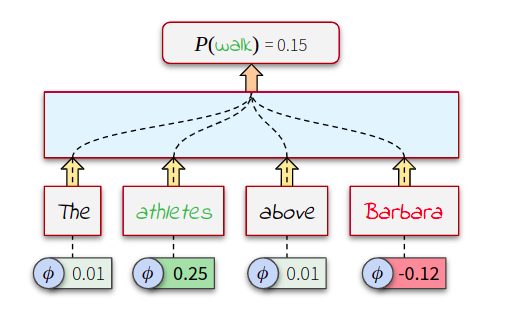

A lot of attribution methods have been proposed over the passed few years. You may have heard of some of them, like LIME, SHAP, Integrated Gradients, or GradCAM. Each of these methods have their own strengths and weaknesses, but has become increasingly harder to make sense of which method is truly the most **faithful** to the actual behaviour of the underlying model. This is a notoriously hard problem, because we don't have access to the "*gold explanation*" of model behaviour: it is, after all, precisely this gold explanation that we are trying to obtain via our feature attribution methods.

In an effort to make more sense of the landscape of attribution methods, [Covert et al. (2021)](https://arxiv.org/pdf/2011.14878.pdf) devised three dimensions that characterise a method:

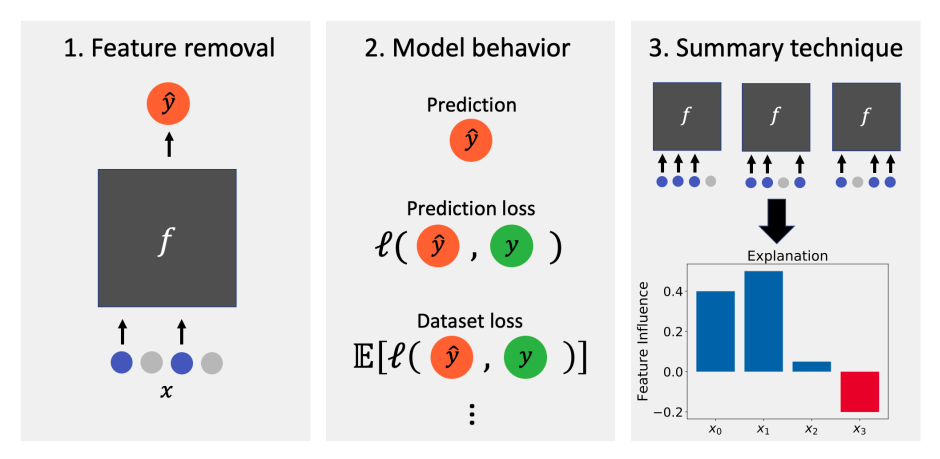

1. The first, feature removal, defines how we deal with removing (subsets of) features from an input. This is often done to create explanations: the behaviour of a model is compared on what happens if we modify parts of our input. Humans generate explanations like this often as well: we explain our behaviour by comparing it to what we could have done instead.

2. The second, model behaviour, is less useful for us, as we will solely be focusing on explaining model *predictions*, and not care about the model loss.

3. The third, summary technique, ties in to the first dimension in how we aggregate the model outputs on the modified inputs that we obtained with our feature removal procedure. At this point you are probably familiar with the Shapley value, this is a specific instance of a summary technique.

These three dimensions lead to the following table that sketches part of the attribution landscape:

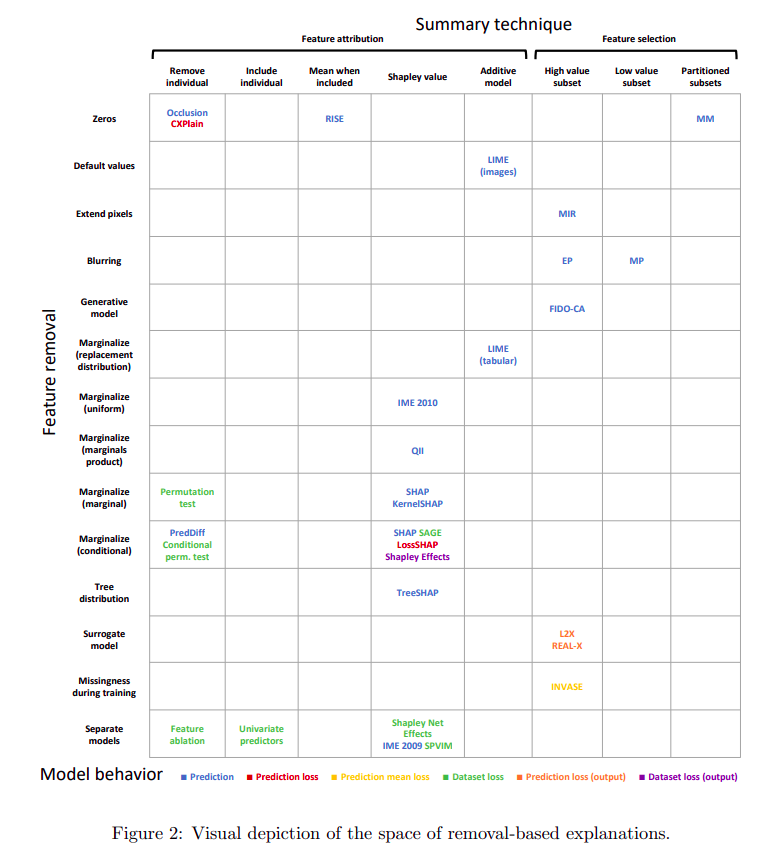

## Assignment
In our assignment we will focus on a small subset of attribution methods, and compare these. We will look into methods that aim to evaluate and quantify the faithfulness of an attribution method. You will use these methods to conduct a small-scale qualitative analysis on a **sentiment classification** model. After all, attribution methods should provide us a better insight into the reasoning of a model, so ideally an attribution will give us a better, more qualitative insight into its behaviour.

## Models and Data

For your experiments, you will make use of the RoBERTa model ([Liu et al. 2019 ](https://arxiv.org/abs/1907.11692)). RoBERTa, as you may recall, is an extension of BERT for which the pretraining procedure has been changed. Importantly, RoBERTa has been trained on more data, with longer sequences. However, it removed the next sentence prediction objective.

We will evaluate our model using the Stanford Sentiment Treebank (or [SST2](https://arxiv.org/abs/1804.07461)) dataset. The dataset consists out of 11,855 movie reviews, each annotated with sentiment. This kind of data is ideal for attribution extraction, as sentiment often contains very clear words which mark the sentiment for that sentence. 

**N.B.: Before you run this cell make sure GPU support is enabled! Some of the methods we will be using are quite compute-heavy.**

In [1]:
#!pip install transformers datasets captum

import transformers
import torch
import os
import numpy as np
import pandas as pd
from typing import *
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from roberta2 import RobertaForSequenceClassification

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def load_model(path):
    tokenizer = AutoTokenizer.from_pretrained(path)
    model = RobertaForSequenceClassification.from_pretrained(path)
    model.eval()
    model.to(DEVICE)

    return model, tokenizer


# We use a fine-tuned roberta model in our experiments
model, tokenizer = load_model("textattack/roberta-base-SST-2")

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


For the sentiment classification task we will make use of Huggingface's `datasets` library, which makes it very easy to load in SST2 and do post-processing on it.

In [2]:
from datasets import load_dataset


# We can directly load in the SST2 dataset
dataset = load_dataset("gpt3mix/sst2")


# We still need to encode the raw sentences based on the tokenizer we're using
def encode(batch):
    encoded = tokenizer(
        batch["text"], 
        padding="longest", 
        truncation=True, 
        max_length=512, 
        return_tensors="pt",
    ).to(DEVICE)

    # Invert labels (0 <> 1), because it's the other way around somehow for roberta
    batch['label'] = (~torch.tensor(batch['label']).bool()).long()
    batch['text'] = [
        tokenizer.tokenize(sen, add_special_tokens=True)
        for sen in batch['text']
    ]

    return {**encoded, **batch}


dataset.set_transform(encode)

Found cached dataset sst2 (/home/martijn/.cache/huggingface/datasets/gpt3mix___sst2/default/0.0.0/90167692658fa4abca2ffa3ede1a43a71e2bf671078c5c275c64c4231d5a62fa)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
orig_embs = model.roberta.embeddings.word_embeddings.weight.data
new_embs = torch.cat((orig_embs, torch.zeros(1, orig_embs.shape[-1]).to(DEVICE)))
model.roberta.embeddings.word_embeddings.weight.data = new_embs
model.roberta.embeddings.word_embeddings.num_embeddings += 1

zero_id = torch.tensor(50265).to(DEVICE)

model.roberta.embeddings.word_embeddings(zero_id)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

<font color='green'><b>ToDo 1</b></font>

Inspect the data you have been given. Make sure you understand what the data looks like, and what the labels mean. Try to iterate over your data, and see what happens if you try to access a single item in the corpus, or multiple at once.

In [4]:
for attr, value in dataset['train'][:2].items():
    print(f"{attr:<15}", value)

input_ids       tensor([[    0,   133,  2751,    16, 19083,     7,    28,     5,   733,   620,
          9348,   128,    29,    92, 45518, 38650, 12801,     8,    14,    37,
           128,    29,   164,     7,   146,    10, 17158,   190,  2388,    87,
         11816, 28797,  2156,  5363,    12, 11428,  5247,  3415,  8234,  1794,
            50,  5031,  1608,  9487,   479,     2,     1,     1,     1,     1,
             1,     1,     1],
        [    0,   133, 39966,  9412, 10986, 18719,     9, 45518,    20,  5736,
             9,     5, 32106, 12801, 26105,    16,    98,  1307,    14,    10,
          6730,     9,  1617,    64,    45, 17327,  6190,  1029,    12,  9408,
         48182, 19709,  2155,  2250,   128,    29,  4939,  3360,     9,   344,
             4,   500,     4,   500,     4, 44107,   128,    29,  2367,    12,
         25581,   479,     2]], device='cuda:0')
attention_mask  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1,

Now that you have inspected the data, let us try to use it alongside the loaded model.

<font color='green'><b>ToDo 2</b></font>

*   Produce a prediction using the model for the first sentence in the dataset.
*   List 5 sentences from the test set for which the model produces **incorrect** predictions.

<font color='red'><b>ToSubmit 1</b></font>
The list of 5 sentences you have found on which the model makes an incorrect prediction. Add a brief caption to the listing in which you state some patterns that you observe (max 50 words).

In [5]:
# Your code here (producing a single prediction)

In [6]:
# Your code here (list 5 sentences with incorrect predictions)

## Attribution Methods

For this workshop, you will look at several existing attribution methods, see how they work and compare and contrast their similarities and differences. For your experiments, you will consider the following attribution methods:

* Feature Ablation
* Shapley Values
* Integrated Gradients
* KernelShap

To make sure these four methods are compatible with subsequent evaluation procedures, we will let each instantiation inherit from an abstract `FeatureAttributor` class. Note that this class also contains a method to retrieve the model logits, which may be of use in your implementation of the attribution methods.

You can use the `visualize_attribution` method to visualize the attributions for a particular method.

In [7]:
from abc import abstractmethod

from captum.attr import visualization
from IPython.display import display, HTML


class FeatureAttributor:
    def __init__(self, model):
        self.model = model

    @abstractmethod
    def attribute(
        self, 
        input_ids: torch.Tensor, 
        baseline_ids: torch.Tensor, 
        target: int,
        **kwargs
    ) -> torch.Tensor:
        """
        Computes the attributions for a single input.

        Parameters
        ----------
        input_ids : torch.Tensor
            shape: (batch_size, sen_len)
        baseline_ids : torch.Tensor
            shape: (batch_size, sen_len)
        target : int
            Output class that is being explained

        Returns
        -------
        attributions : torch.Tensor
            shape: (sen_len,)
        """
        pass

    def logits(self, input_ids, target=None):
        squeeze_output = input_ids.ndim == 1
        if squeeze_output:
            input_ids = input_ids.unsqueeze(0)

        with torch.no_grad():
            logits = self.model(input_ids).logits[:, target]
            
        if squeeze_output:
            logits = logits.squeeze()

        return logits


def visualize_attribution(sen: List[str], attributions: torch.Tensor, normalize: bool = True):
    if normalize:
        attributions /= torch.max(attributions.abs())

    raw_html = visualization.format_word_importances(
        sen, attributions
    )
    html = HTML(raw_html)
    display(html)

### Feature Ablation

Feature Ablation ([Li, Monroe and Jurafsky, 2016](https://arxiv.org/abs/1612.08220)) is a simple attribution method. We replace individiual tokens in the sentence with some baseline token, and measure the difference in output between the original sentence and the modified one. We then assign the resulting difference to the replaced token. This procedure is summarised in the following formula, where $a_{i}$ is the attribution score for the token at position $i$, $\mathcal{M}$ is the model and $\mathcal{F}_{i}$ is the replacement method at position $i$.

$$a_{i}(x) = \mathcal{M}(x) - \mathcal{M}(\mathcal{F}_i(x))$$

<font color='blue'><b>ToThink 1</b></font> Consider how we may model the exclusion of one or multiple tokens from our input. Do you completely remove the feature? Replace it with a default token? Or sample it from a distribution? What impact do these choices have on your explanations?

<font color='green'><b>ToDo 3</b></font>
Implement the ablation attribution method below. You can test your method on the example sentence that has been provided.

In [8]:
class AblationAttributor(FeatureAttributor):
    def attribute(
        self, 
        input_ids: torch.Tensor, 
        baseline_ids: torch.Tensor, 
        target: int,
    ) -> torch.Tensor:
        ### Start Student ###
        sen_len = input_ids.shape[-1]
        ablated_feature_matrix = input_ids.repeat(sen_len, 1)
        ablated_feature_matrix[range(sen_len), range(sen_len)] = baseline_ids
        with torch.no_grad():
            full_logit = self.logits(input_ids, target)
            ablated_logits = self.logits(ablated_feature_matrix, target)

        attribution_scores = full_logit - ablated_logits

        return attribution_scores
        ### End Student ###


sen = "I wish I liked it more, although I did not dislike it"
item = {
    "input_ids": tokenizer(sen, return_tensors='pt').to(DEVICE)['input_ids'].squeeze(),
    "text": tokenizer.tokenize(sen, add_special_tokens=True),
    "label": torch.tensor(1),
}
input_ids = item['input_ids']
sen_len = len(item['text'])

baseline_id = tokenizer.unk_token_id
baseline_ids = torch.tensor([baseline_id] * sen_len, device=DEVICE)
label = item['label'].item()

ablation_attributor = AblationAttributor(model)
ablation_attributions = ablation_attributor.attribute(input_ids, baseline_ids, label)

for w, phi in zip(item['text'], ablation_attributions):
    print(f"{w:<15} {phi.item():.3f}")

visualize_attribution(item['text'], ablation_attributions)
print(ablation_attributor.logits(input_ids.unsqueeze(0)))

<s>             -0.127
I               -0.638
Ġwish           -2.191
ĠI              -0.824
Ġliked          -0.515
Ġit             -0.148
Ġmore           -0.150
,               -0.140
Ġalthough       -0.998
ĠI              0.080
Ġdid            -0.261
Ġnot            2.196
Ġdislike        1.398
Ġit             0.665
</s>            0.608


tensor([[[ 0.1252, -0.1424]]], device='cuda:0')


### Shapley Values

Another approach to assigning attribution scores comes from game theory. Shapley values ([Shapley, 1951](https://www.rand.org/pubs/research_memoranda/RM0670.html)) provide a framework for the assignment of contributions to players in a team. More specifically, we can estimate the contributions of a player by comparing the results of all coalitions including our player to those same coalitions without our player. These differences indicate the contributions of our player towards the game, and can be considered their attribution. The mathematical formulation for this procedure is as follows:

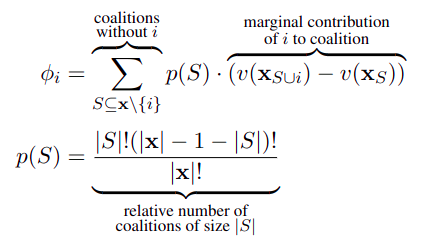

We can translate this concept to NLP by considering the team to be the input to the model. As such the players in our imaginary game have become the tokens in the input. We can evaluate the performance by looking at all possible coalitions (i.e. subsets) of our input with respect to a single token, either including or excluding it. 

<font color='blue'><b>ToThink 2</b></font> How does the computation of a Shapley values scale, in terms of the number of input features?

<font color='green'><b>ToDo 4</b></font>
Fill in the missing part in `ShapleyAttributor.attribute` below. The model outputs have been pre-computed (`coalition_logits`), so all that is left to do is to finish the Shapley computation steps as outlined in the mathematical formulation above. 

In [9]:
from itertools import chain, combinations
from math import factorial
from tqdm.notebook import tqdm as tqdm_notebook


def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))


def coalitions_without_i(sen_len, i):
    features_not_i = [j for j in range(sen_len) if j != i]
    for coalition in powerset(features_not_i):
        yield coalition


class ShapleyAttributor(FeatureAttributor):
    def attribute(
        self,
        input_ids: torch.Tensor,
        baseline_ids: torch.Tensor,
        target: int,
    ) -> torch.Tensor:
        sen_len = input_ids.shape[-1]

        coalition_logits, coalition_to_index = self.compute_coalition_logits(
            input_ids, baseline_ids, target
        )

        shapley_values = torch.zeros(sen_len)

        for i in range(sen_len):
            for S in coalitions_without_i(sen_len, i):
                S_i = tuple(sorted(S + (i,)))
                index_S = coalition_to_index[S]
                index_S_i = coalition_to_index[S_i]

                ### Start Student ###
                normalizer = (
                    factorial(len(S)) * factorial(sen_len - 1 - len(S))
                ) / factorial(sen_len)

                diff = coalition_logits[index_S_i] - coalition_logits[index_S]

                shapley_values[i] += normalizer * diff
                ### End Student ##

        return shapley_values

    def compute_coalition_logits(self, input_ids, baseline_ids, target):
        """
        Computes the model output for all possible coalitions, in batches.

        Returns
        -------
        coalition_logits : torch.Tensor
            shape: (2**sen_len,)
            The output logit for each coalition
        coalition_to_index : Dict[Tuple[int], int]
            Dictionary mapping a coalition tuple to its index in the 
            coalition_logits tensor.
        """
        sen_len = input_ids.shape[-1]
        num_coalitions = 2**sen_len

        coalitions = torch.zeros(num_coalitions, sen_len, dtype=torch.long).to(DEVICE)
        coalitions += baseline_ids  # set baseline as default

        coalition_to_index = {}

        for idx, coalition in enumerate(powerset(range(sen_len))):
            coalition_to_index[coalition] = idx
            if len(coalition) > 0:
                coalition = list(coalition)
                coalitions[idx, coalition] = input_ids[coalition]

        coalition_logits = torch.zeros(num_coalitions)
        batch_size = 1024
        batch_iterator = torch.split(coalitions, batch_size)
        for batch_idx, batch in tqdm_notebook(
            enumerate(batch_iterator), total=len(batch_iterator)
        ):
            with torch.no_grad():
                batch_logits = self.logits(batch, target)
            coalition_logits[
                batch_idx * batch_size : (batch_idx + 1) * batch_size
            ] = batch_logits

        return coalition_logits, coalition_to_index


shapley_attributor = ShapleyAttributor(model)
shapley_attributions = shapley_attributor.attribute(input_ids, baseline_id, label)

visualize_attribution(item["text"], shapley_attributions)

shapley_attributions

  0%|          | 0/32 [00:00<?, ?it/s]

tensor([ 0.0162, -0.0816, -1.0000, -0.2621,  0.4633, -0.0195, -0.4085, -0.0085,
        -0.0466, -0.0130,  0.1038,  0.3552,  0.0014,  0.0930,  0.0089])

In [10]:
from scipy.stats import spearmanr

x = torch.tensor([ 0.0163, -0.0812, -1.0000, -0.2617,  0.4634, -0.0195, -0.4079, -0.0085,
        -0.0468, -0.0128,  0.1039,  0.3552,  0.0014,  0.0933,  0.0091])

y = torch.tensor([ 0.0215, -0.1072, -1.3189, -0.3456,  0.6110, -0.0255, -0.5386, -0.0113,
        -0.0617, -0.0171,  0.1368,  0.4686,  0.0020,  0.1226,  0.0118])

spearmanr(x, y)

SpearmanrResult(correlation=1.0, pvalue=0.0)

One of the main reasons to be using Shapley values as an explanation tool is that it is the unique method to satisfy various attractive "*axioms*", i.e. theoretical properties that are guaranteed to be true. One of these is **completeness**, which states that all attributions must sum up to the model's output on the input, minus the model's output on the baseline:

$$\sum_i\phi_i = f(x) - f(x')$$

The difference between the sum of attributions and model output is often referred to as the convergence $\delta$. 

<font color='green'><b>ToDo 5</b></font>
Fill in the method for computing the compleness in the method defined below. Is the $\delta$ close to zero? Due to numerical instabilities it may be possible that is not exactly 0.

In [11]:
def completeness(attributor, input_ids, baseline_ids, target, **kwargs):
    attributions = attributor.attribute(input_ids, baseline_ids, target, **kwargs)

    with torch.no_grad():
        logit = attributor.logits(input_ids, target)
        baseline_logit = attributor.logits(baseline_ids, target)

    return attributions.sum() - (logit - baseline_logit)


completeness(shapley_attributor, input_ids, baseline_ids, label)

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(-0.0027, device='cuda:0')

### KernelSHAP

Directly computing Shapley values is an expensive process, as it scales exponentially with the size of the input. Because of this, computing Shapley values for larger inputs becomes infeasible, especially over larger datasets. As such, approximations are needed to compute these values.

KernelSHAP ([Lundberg and Lee, 2017](https://arxiv.org/abs/1705.07874)) is one such approximation. It seeks to reduce the complexity to a managable scale by using a different approach called LIME ([Ribeiro, Singh, and Guestrin, 2016](https://arxiv.org/abs/1602.04938)). LIME seeks to produce a linear approximation of a model, and inspect this surrogate model. It trains a linear model on a simplified input, noting the presence or absence of individual training features, which produces a model which is able to mimic the original model. However, for this process a loss function, weighing kernel and a regularization term are needed. In Lunderberg and Lee (2017), they show that by carefully choosing these parameters, the regression coefficients of the model resemble the Shapley values corresponding to these.

<font color='green'><b>ToDo 6</b></font>
Fill in the missing part in `ShapAttributor.attribute` below. You can make use of the `captum` implementation of KernelSHAP (check out the API [here](https://captum.ai/api/kernel_shap.html)). Make sure that you now feed the `input_ids` to the method, and not the embeddings. If we were to do the latter case the individual units in the embedding would be considered to be individual features, which would mess up the Shapley computation.

<font color='blue'><b>ToThink 3</b></font> Does KernelSHAP satisfy the completeness axiom?

In [12]:
from captum.attr import KernelShap


def f(input_ids):
    return model(input_ids).logits

class ShapAttributor(FeatureAttributor):
    def attribute(
        self, 
        input_ids: torch.Tensor, 
        baseline_ids: torch.Tensor, 
        target: int,
    ) -> torch.Tensor:
        ### Start Student ###
        #print('input_ids\t', input_ids)
        #print('baseline\t', baseline_ids)
        #print('target\t\t', target)
        ks = KernelShap(f)

        ks_attributions = ks.attribute(
            input_ids.unsqueeze(0), 
            target=target,
            baselines=baseline_ids.unsqueeze(0),
            n_samples=512,
            perturbations_per_eval=512,
            show_progress=False,
        )
        ks_attributions = ks_attributions.squeeze()

        return ks_attributions
        ### End Student ###


shap_attributor = ShapAttributor(model)
shap_attributions = shap_attributor.attribute(input_ids, baseline_ids, label)
print(shap_attributions)
visualize_attribution(item['text'], shap_attributions)

tensor([-0.2076, -0.3180, -1.5116,  0.1121,  0.6783,  0.0071, -0.7171, -0.0288,
         0.1886, -0.0067,  0.1759,  0.3962,  0.0882,  0.2559, -0.1650],
       device='cuda:0')


### Integrated Gradients

Integrated Gradients ([Sundararajan, Taly, and Yan, 2017](https://arxiv.org/abs/1703.01365)) seeks to assign attributions through measuring differences in output of a model as the input space changes. More specifically, we are looking to measure gradients along the path from some baseline input to our original input. In this way, Integrated Gradients performs Saliency Mapping at multiple points along the straightline path from a baseline input $x^\prime$ to the original input $x$. This operation is mathematically defined as:

$$ a_{i}(x)=\left(x_{i}-x_{i}^{\prime}\right) \times \int_{\alpha=0}^{1} \frac{\partial F\left(x^{\prime}+\alpha \times\left(x-x^{\prime}\right)\right)}{\partial x_{i}} d \alpha$$

As you can read in the original paper of IG, this path integral actually approximates a quantity from game theory as well, the Aumann-Shapley value, which can roughly be understood as the extension of the (discrete) Shapley value to the case in which the players are continuous. Fairly vague and hard to wrap your head around, so don't worry to much about it 😃.

<font color='green'><b>ToDo 7</b></font>
Fill in the missing part in `IGAttributor.attribute` below. You can make use of the `captum` implementation of Integrated Gradients. Make sure to have a look at the documentation of their implementation here: https://captum.ai/api/integrated_gradients.html

Important to keep in mind is that Integrated Gradients operate on the embedding space, and as such the method expects the input to be the word embeddings, and not the input ids. You can access the word embeddings of RoBERTa as follows: `model.roberta.embeddings.word_embeddings(..)`

<font color='blue'><b>ToThink 4</b></font> Does Integrated Gradients satisfy the completeness axiom? Does the convergence $\delta$ depend on the number of interpolation steps that are used to approximate the path integral?

In [13]:
from captum.attr import IntegratedGradients


def model_forward(inputs_embeds):
    return model(inputs_embeds=inputs_embeds).logits


class IGAttributor(FeatureAttributor):
    def attribute(
        self, 
        input_ids: torch.Tensor, 
        baseline_ids: torch.Tensor, 
        target: int,
        n_steps: int = 50,
    ) -> torch.Tensor:
        ### Start Student ###
        ig = IntegratedGradients(model_forward)

        inputs_embeds = model.roberta.embeddings.word_embeddings(input_ids.unsqueeze(0))
        baseline_embeds = model.roberta.embeddings.word_embeddings(baseline_ids.unsqueeze(0))

        ig_attributions = ig.attribute(
            inputs_embeds, 
            target=target, 
            baselines=baseline_embeds, 
            n_steps=n_steps
        )
        ig_attributions = ig_attributions.sum(-1).squeeze()
    
        return ig_attributions
        ### End Student ###


ig_attributor = IGAttributor(model)
ig_attributions = ig_attributor.attribute(input_ids, baseline_ids, label)
print(ig_attributions)
visualize_attribution(item['text'], ig_attributions)

tensor([-0.1314,  0.0474, -1.8137, -0.3547,  1.0918, -0.0942, -1.0868, -0.0475,
        -0.5474, -0.2604,  0.1297,  0.7881,  0.1841,  1.0130, -0.6355],
       device='cuda:0', dtype=torch.float64, grad_fn=<SqueezeBackward0>)


### Gradient-weighted Attention Rollout

In [14]:
from captum._utils.common import _get_module_from_name
class PyTMinMaxScalerVectorized(object):
    """
    Transforms each channel to the range [0, 1].
    """

    def __init__(self, dimension=-1):
        self.d = dimension

    def __call__(self, tensor):
        d = self.d
        scale = 1.0 / (
            tensor.max(dim=d, keepdim=True)[0] - tensor.min(dim=d, keepdim=True)[0]
#            tensor.max() - tensor.min()
        )
        tensor.mul_(scale).sub_(tensor.min(dim=d, keepdim=True)[0])
#        tensor.mul_(scale).sub_(tensor.min())
        return tensor

class GradientRolloutAttributor(FeatureAttributor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.scaler = PyTMinMaxScalerVectorized()

    def _calculate_gradients(self, output, index, do_relprop=True):
        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot_vector = (torch.nn.functional
                .one_hot(
                        # one_hot requires ints
                        torch.tensor(index, dtype=torch.int64),
                        num_classes=output.size(-1)
                    )
                # but requires_grad_ needs floats
                .to(torch.float)
            ).to(output.device)

        hot_output = torch.sum(one_hot_vector.clone().requires_grad_(True) * output)
        self.model.zero_grad()
        hot_output.backward(retain_graph=True)

    def generate_rollout_attn_gradcam(self, input_ids, attention_mask, index=None, start_layer=0):
        # rule 5 from paper
        def avg_heads(cam, grad):
            return (grad * cam).clamp(min=0).mean(dim=-3)

        # rule 6 from paper
        def apply_self_attention_rules(R_ss, cam_ss):
            return torch.matmul(cam_ss, R_ss)


        output = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]

        self._calculate_gradients(output, index, do_relprop=False)

        num_tokens = input_ids.size(-1)
        R = torch.eye(num_tokens).expand(output.size(0), -1, -1).clone().to(output.device)

        blocks = _get_module_from_name(self.model, "roberta.encoder.layer")
        for i, blk in enumerate(blocks):
            if i < start_layer:
                continue
            grad = blk.attention.self.get_attn_gradients().detach()
            cam = blk.attention.self.get_attn().detach()
            cam = avg_heads(cam, grad)
            joint = apply_self_attention_rules(R, cam)
            R += joint
        # 0 because we look at the influence *on* the CLS token
        return R[:, 0]

    def attribute(
        self,
        input_ids: torch.Tensor,
        baseline_ids: torch.Tensor,
        target: int,
    ) -> torch.Tensor:
        sen_len = input_ids.shape[-1]
        squeeze_output = input_ids.ndim == 1
        if squeeze_output:
            input_ids = input_ids.unsqueeze(0)
        #explanation_neg = self.generate_rollout_attn_gradcam(input_ids, torch.ones_like(input_ids), index=0, start_layer=8)
        #explanation_neg[:,0] = 0
        #explanation_neg[:,-1] = 0
        #print("n ", explanation_neg * -1)
        #norm_neg = self.scaler(explanation_neg) * -1
        #print("nn", norm_neg)
        explanation = self.generate_rollout_attn_gradcam(input_ids, torch.ones_like(input_ids), index=1, start_layer=8)
        if target == 0:
            explanation *= -1
        #explanation_pos[:,0] = 0
        #explanation_pos[:,-1] = 0
        #concat = self.scaler(torch.cat([explanation_neg, explanation_pos]))
        #print("CONCAT", concat)
        #print("p ", explanation_pos)
        #norm_pos = self.scaler(explanation_pos)
        #print("pn", norm_pos)
        #explanation = norm_pos + norm_neg
        if squeeze_output:
            explanation = explanation.squeeze()
        return explanation

rollout_attributor = GradientRolloutAttributor(model)
rollout_attributions = rollout_attributor.attribute(input_ids, baseline_ids, label)
rollout_attributions = rollout_attributions.squeeze(0)
print(rollout_attributions)
for w, phi in zip(item['text'], rollout_attributions):
    print(f"{w:<15} {phi.item():.3f}")

norm_rollout_attributions = rollout_attributions
norm_rollout_attributions[0] = 0
norm_rollout_attributions[-1] = 0
norm_rollout_attributions = rollout_attributor.scaler(rollout_attributions.unsqueeze(0)).squeeze()

visualize_attribution(item['text'], norm_rollout_attributions)

#rollout_attributions = rollout_attributor.attribute(input_ids, baseline_ids, 1-label)
#rollout_attributions = rollout_attributions.squeeze(0)
#print(rollout_attributions)
#for w, phi in zip(item['text'], rollout_attributions):
#    print(f"{w:<15} {phi.item():.3f}")
#
#visualize_attribution(item['text'], rollout_attributions)


tensor([1.0045e+00, 3.4259e-03, 1.1039e-03, 3.3061e-04, 3.2593e-03, 5.2123e-03,
        1.8433e-03, 6.1095e-03, 6.9988e-03, 4.2110e-03, 6.0394e-03, 7.6994e-03,
        1.6251e-03, 5.3048e-03, 4.0761e-03], device='cuda:0')
<s>             1.005
I               0.003
Ġwish           0.001
ĠI              0.000
Ġliked          0.003
Ġit             0.005
Ġmore           0.002
,               0.006
Ġalthough       0.007
ĠI              0.004
Ġdid            0.006
Ġnot            0.008
Ġdislike        0.002
Ġit             0.005
</s>            0.004


In [15]:
ta = item['text']
print("Ablation")
visualize_attribution(item['text'], ablation_attributions)
ablation_sorted_ix = (-ablation_attributions[1:-1].cpu().numpy()).argsort()
ablation_sorted = (ablation_attributions[1:-1]).sort(descending=True)[0]
visualize_attribution([ta[n] for n in ablation_sorted_ix], ablation_sorted)
print("Shapley Values")
visualize_attribution(item["text"], shapley_attributions)
shapley_sorted_ix = (-shapley_attributions[1:-1].cpu().numpy()).argsort()
shapley_sorted = (shapley_attributions[1:-1]).sort(descending=True)[0]
visualize_attribution([ta[n] for n in shapley_sorted_ix], shapley_sorted)
print("KernelShap")
visualize_attribution(item['text'], shap_attributions)
shap_sorted_ix = (-shap_attributions[1:-1].cpu().numpy()).argsort()
shap_sorted = (shap_attributions[1:-1]).sort(descending=True)[0]
visualize_attribution([ta[n] for n in shap_sorted_ix], shap_sorted)
print("IntegratedGradients")
visualize_attribution(item['text'], ig_attributions)
ig_sorted_ix = (-ig_attributions[1:-1].detach().cpu().numpy()).argsort()
ig_sorted = (ig_attributions[1:-1]).sort(descending=True)[0]
visualize_attribution([ta[n] for n in ig_sorted_ix], ig_sorted)
print("Rollout")
visualize_attribution(item['text'], rollout_attributions)
rollout_sorted_ix = (-ig_attributions[1:-1].detach().cpu().numpy()).argsort()
rollout_sorted = (rollout_attributions[1:-1]).sort(descending=True)[0]
visualize_attribution([ta[n] for n in rollout_sorted_ix], rollout_sorted)


Ablation


Shapley Values


KernelShap


IntegratedGradients


Rollout


## Baselines
<font color='green'><b>ToDo 7.1</b></font>
In the previous cells we have been using an `<unk>` token as a baseline. How do the attributions change if you use a different fixed token instead? You could check another neutral token, like `<pad>`, a zero-valued baseline, or something else you think of yourself.

## Evaluation

Evaluating attribution methods is still a topic of debate in the scientific community. Several methods exsist which look at different aspects of these methods to gauge how well they explain the behaviour of the model. For this workshop, we will focus on three such methods:

- Comprehensiveness
- Sufficiency
- Area

### Comprehensiveness
Comprehensiveness ([DeYoung et al., 2020](https://aclanthology.org/2020.acl-main.408/)) is the average difference of the change in predicated class probability before and after removing the top k% of tokens according to the used attribution method. In doing so, we shorten the original sentence by removing the designated tokens. It is expected that by removing the top tokens, the predicated class probability will lower as important information for the prediction of the model should be captured in the top tokens. It is defined as:

$$\operatorname{Comp}(k)=\frac{1}{N} \sum_{i=1}^{N} p(\hat{y} \mid \boldsymbol{x}_{i}) - p(\hat{y} \mid \boldsymbol{x}_{i}^{(k)}),$$

where $N$ is the number of inputs, $\hat{y}$ the predicted class, $x_i$ the $i$-th input sentence and $x_{i}^{(k)}$ the modified sentence with the top k% tokens removed.

### Sufficiency
Sufficiency ([DeYoung et al, 2020](https://aclanthology.org/2020.acl-main.408/)) is the average difference of the change in predicated class probability before and after keeping only the top k% of tokens according to the used attribution method. This method is very similar to Comprehensiveness, but flips the premise and seeks to identify how much information is captured in only the top k% of tokens. This score is defined similarly to Comprehensiveness, only changing $x_{i}^{(k)}$ to mean the modififed sentence with only the top k% tokens.


### AUC
AUC ([Kim et al., 2020](https://aclanthology.org/2020.emnlp-main.255/)), or Area-Under-the-Curve, seeks to examine how the probability for a predicted class changes as the input is pruned. We follow the generated attributions in deciding which tokens to remove from the input, starting with those with high attributions. In this way, we expect the probability of the predicted class to fall rapidly, as those tokens that caused its prediction are removed from the sentence. We reduce this process to a singular number by computing the area under the curve of the graph that would result from plotting the predicted class probability against the number of remaining tokens in the input. 

A common value for $k$ is $20\%$.

<font color='green'><b>ToDo 8</b></font>
Fill in the three methods for comprehensiveness, sufficiency, and AUC below.

<font color='green'><b>ToDo 9</b></font> 
Compute the methods for the example sentence we have been using. Do you observe any differences between the methods?

<font color='blue'><b>ToThink</b></font>
What impact does a token like *not* have on the evaluation scores? Can attribution methods properly handle negation, which invokes a form of feature *interaction*?

In [16]:
def comprehensiveness(model, attributions, input_ids, target, k=0.2, baseline=None):
    ### Begin Student ###
    sen_len = input_ids.shape[-1]
    flk = k
    if isinstance(k, float):
        k = int(sen_len * k)
#    if k == 0:
#        print("COMP", flk, sen_len, k)

    top_k = (-attributions[1:-1]).argsort()[:k] + 1
    # top k removed
    #modified_input = input_ids[[i not in top_k for i in range(sen_len)]]
    modified_input = torch.LongTensor([t if n not in top_k else baseline for n, t in enumerate(input_ids)]).to(DEVICE)
    with torch.no_grad():
        modified_logit = model(modified_input.unsqueeze(0)).logits
        full_logit =  model(input_ids.unsqueeze(0)).logits
        modified_softmax = modified_logit.softmax(-1)[0, target]
        full_softmax = full_logit.softmax(-1)[0, target]
    return (full_softmax - modified_softmax).item()
    ### End Student ###


def sufficiency(model, attributions, input_ids, target, k=0.2, baseline=None):
    ### Begin Student ###
    sen_len = input_ids.shape[-1]
    flk = k
    if isinstance(k, float):
        k = int(sen_len * k)

#    if k == 0:
#        print("SUFF", flk, sen_len, k)
    top_k = (-attributions[1:-1]).argsort()[:k] + 1

    # top k retained
#    modified_input = input_ids[
#        [(i in top_k or i in [0, sen_len-1]) for i in range(sen_len)]
#    ]      
    modified_input = torch.LongTensor([t if n in top_k else baseline for n, t in enumerate(input_ids)]).to(DEVICE)

    with torch.no_grad():
        modified_logit = model(modified_input.unsqueeze(0)).logits
        full_logit =  model(input_ids.unsqueeze(0)).logits

        modified_softmax = modified_logit.softmax(-1)[0, target]
        full_softmax = full_logit.softmax(-1)[0, target]

    return (full_softmax - modified_softmax).item()
    ### End Student ###


def auc(model, attributions, input_ids, target, k=0.2, baseline=None):
    ### Begin Student ###
    sen_len = input_ids.shape[-1]
    flk = k
    k = int(sen_len * k)
#    if k == 0:
#        print("AUC:", flk, sen_len, k)

    # most important -> least important
    top_k = (-attributions[1:-1]).argsort() + 1
    top_k = top_k.tolist()
    
    auc_list = []
    
    for i in range(k):
        #modified_input = input_ids[sorted(top_k[i:] + [0,sen_len-1])]
        modified_input = torch.LongTensor([t if n in (top_k[i:] + [0, sen_len-1]) else baseline_id for n, t in enumerate(input_ids)]).to(DEVICE)

        with torch.no_grad():
            modified_logit = model(modified_input.unsqueeze(0)).logits
            modified_softmax = modified_logit.softmax(-1)[0, target]

        auc_list.append(modified_softmax.item())

    return np.mean(auc_list)
    ### End Student ###

In [17]:
evaluate = comprehensiveness
sen_len = len(input_ids)

for name, attributions in [
    ("rollout", rollout_attributions),
    ("ablation", ablation_attributions),
    ("shapley", shapley_attributions),
    ("ig", ig_attributions),
    ("shap", shap_attributions),
]:
    #print(name, attributions.shape)
    print(f"{name:<10} {evaluate(model, attributions, input_ids, label, baseline=baseline_id):.3f}")

rollout    0.423
ablation   0.294
shapley    0.428
ig         0.416
shap       0.416


We now have all the steps in place to evaluate our attribution methods on a corpus, and compute its faithfulness using the three methods we have defined in the previous step.

Because of the computational constraints of the exact Shapley Values, we will leave out this method here, and rely on the approximation provided by KernelSHAP.

<font color='red'><b>ToSubmit 2</b></font>
Create a table for the attribution evaluation scores with an attribution method on each row, and an evaluation method on each column. Your table will be 3x3: three attribution methods, and 3 evaluation methods. To save computation time you may opt to compute this table on a subset of the test set (say, 300 items).

Create 3 tables in total for 3 baselines: `<pad>`, `<unk>`, and a zero-valued baseline.

In [18]:
def evaluate_corpus(corpus, attributor, attributor_name):
    all_attributions = []
    scores = []

    for input_ids, attention_mask, label in tqdm_notebook(zip(
        corpus['input_ids'], 
        corpus['attention_mask'], 
        corpus['label']
    ), total=corpus['input_ids'].shape[0]):
        input_ids = input_ids[attention_mask.bool()]
        baseline_ids = torch.zeros_like(input_ids) + baseline_id

        attributions = attributor.attribute(input_ids, baseline_ids, label)
        all_attributions.append(attributions)
        for k in [0.1, 0.2, 0.5]:
            comp_score = comprehensiveness(model, attributions, input_ids, label, k=k, baseline=baseline_id)
            suff_score = sufficiency(model, attributions, input_ids, label, k=k, baseline=baseline_id)
            auc_score  = auc(model, attributions, input_ids, label, k=k, baseline=baseline_id)

            scores.append([attributor_name, k, comp_score, suff_score, auc_score])
        
    scores_df = pd.DataFrame(scores, columns=["method", "k", "comp", "suff", "auc"])
    return all_attributions, scores_df
    

sample_size = 300
sample = dataset['test'][:sample_size]

for bl in [tokenizer.unk_token_id]:#, tokenizer.pad_token_id, 0]: 
    baseline_id = bl
    evrollout_attributions, rollout_df = evaluate_corpus(sample, rollout_attributor, "rollout")
    evablation_attributions, ablation_df = evaluate_corpus(sample, ablation_attributor, "ablation")
    evig_attributions, ig_df = evaluate_corpus(sample, ig_attributor, "ig")
    evshap_attributions, shap_df = evaluate_corpus(sample, shap_attributor, "shap")

    combined_df = pd.concat([ablation_df, ig_df, shap_df, rollout_df])
    display(combined_df.groupby(["method", "k"]).mean())

  0%|          | 0/300 [00:00<?, ?it/s]

/home/martijn/mambaforge/envs/hug/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martijn/mambaforge/envs/hug/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/300 [00:00<?, ?it/s]

/home/martijn/mambaforge/envs/hug/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martijn/mambaforge/envs/hug/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/300 [00:00<?, ?it/s]

/home/martijn/mambaforge/envs/hug/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martijn/mambaforge/envs/hug/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/300 [00:00<?, ?it/s]

/home/martijn/mambaforge/envs/hug/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martijn/mambaforge/envs/hug/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/martijn/mambaforge/envs/hug/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martijn/mambaforge/envs/hug/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/martijn/mambaforge/envs/hug/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martijn/mambaforge/envs/hug/lib/python3.8/site-packages/numpy/core/_method

comp      suff       auc
method   k                                
ablation 0.1  0.203222  0.078443  0.888126
         0.2  0.341493  0.007975  0.788547
         0.5  0.434708 -0.030303  0.635704
ig       0.1  0.162245  0.065029  0.913884
         0.2  0.295847  0.010665  0.830482
         0.5  0.459978 -0.016467  0.661165
rollout  0.1  0.089329  0.098556  0.929733
         0.2  0.187155  0.065002  0.875949
         0.5  0.332917  0.006345  0.753861
shap     0.1  0.214797  0.028942  0.896568
         0.2  0.428843 -0.011099  0.771816
         0.5  0.624592 -0.036071  0.539979

In [19]:
combined_df[['method', 'comp', 'suff', 'auc']].groupby("method").mean()

,comp,suff,auc
method,,,
ablation,0.326475,0.018705,0.769207
ig,0.306023,0.019742,0.800330
rollout,0.203134,0.056634,0.852147
shap,0.422744,-0.006076,0.733953


<font color="red"><b>ToSubmit 3</b></font>
Using the attributions you have computed, perform a qualitative analysis. You can focus on questions like:
- On what types of sentences do the attribution evaluation methods give *bad* scores? 
- Are there sentences where one attribution method scores much better than the others?
- Related to the ToThink question of above: how do attribution methods with word interactions like negation (*not bad at all*) and adverbials (*incredibly bad*)? How do such interactions impact attribution evaluation methods?

Combined with the two ToSubmit points from above, write up a brief paper (2 pages, [ACL template](https://www.overleaf.com/latex/templates/acl-rolling-review-template/jxbhdzhmcpdm)). Your paper can fully focus on answering the ToSubmit points, i.e. there is no need to give it a full paper structure (introduction->related->methods->etc.). Try to be succinct in addressing the qualitative analysis.

## Possible Extensions 
*(Second project only)*

- Incorporate **Feature Interaction** methods, that explain a prediction not just in terms of importance of a single feature, but also in terms of features that interacted. A good method for this would be [Integrated Hessians](https://arxiv.org/abs/2002.04138), which provide a natural extension of Integrated Gradients to feature interactions.
- Incorporate **conditional baselines**, that model feature absence as a probabality distribution conditioned on the present features. An example of a method that utilises this is [Input Marginalization](https://aclanthology.org/2020.emnlp-main.255.pdf).